## DNN应力应变曲线

In [52]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [53]:
current_directory = os.getcwd()
print(current_directory)

/home/redfu/work/Constitutive_Equation/stress_strain_fitting


In [54]:
# 设置数据类型
DTYPE = torch.float32

# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

df = {}
# 读取数据
url = 'data/power_law_data.xlsx'

df = pd.read_excel(url, sheet_name=None)
data_HF = [[k, v] for k, v in df.items()]  # k is the sheet name, v is the pandas df
# 循环遍历 data_HF 列表并获取下标
data_train=pd.DataFrame()
data_valid=pd.DataFrame()
for i, (sheet_name, sheet_data) in enumerate(data_HF):
    if i==2:
        data_valid=sheet_data
    else:
        data_train=pd.concat([data_train, sheet_data], ignore_index=True)

df_hf = pd.concat([data_train, data_valid], ignore_index=True)


x1_d_HF = torch.tensor(data_train['shear rate'].values, dtype=torch.float32).view(-1, 1)
x2_d_HF = torch.tensor(data_train['n'].values, dtype=torch.float32).view(-1, 1)
y1_d_HF = torch.tensor(data_train['stress'].values, dtype=torch.float32).view(-1, 1)

x1_d_HF=torch.log10(x1_d_HF)
y1_d_HF=torch.log10(y1_d_HF)
# 计算边界

x1min, x1max = torch.min(x1_d_HF), torch.max(x1_d_HF)
x2min, x2max = torch.min(x2_d_HF), torch.max(x2_d_HF)
y1min, y1max = torch.min(y1_d_HF), torch.max(y1_d_HF)
# 索引3,4,5为对数化
lb = torch.tensor([x1min, x2min, y1min], dtype=torch.float32).numpy()
ub = torch.tensor([x1max, x2max,y1max], dtype=torch.float32).numpy()
# 归一化函数
def norm(vectors, lb, ub):
    normalized_vectors = (vectors - lb) / (ub - lb)
    return normalized_vectors

x1_d_HF = norm(x1_d_HF, lb[0], ub[0])
x2_d_HF = norm(x2_d_HF, lb[1], ub[1])
y1_d_HF = norm(y1_d_HF, lb[2], ub[2])
# 合并数据
X_data_HF = torch.cat([x1_d_HF, x2_d_HF], dim=1)
y_data_HF= torch.cat([y1_d_HF], dim=1) # 默认训练储存模量

Xy_data_HF = torch.cat([X_data_HF,y_data_HF], dim=1)

Shuffle = False # 是否打乱训练
if Shuffle:
    Xy_data_HF = Xy_data_HF[torch.randperm(Xy_data_HF.size(0))]
    #Xy_data_LF = Xy_data_LF[torch.randperm(Xy_data_LF.size(0))]
    X_data_HF = Xy_data_HF[:, 0:4]
    y_data_HF = Xy_data_HF[:, 4:5]
    #X_data_LF = Xy_data_LF[:, 0:3]
    #y_data_LF = Xy_data_LF[:, 3:4]

# 定义模型
in_dim, out_dim = 2, 1

In [55]:
x1_d_valid = torch.tensor(data_valid['shear rate'].values, dtype=torch.float32).view(-1, 1)
x2_d_valid = torch.tensor(data_valid['n'].values, dtype=torch.float32).view(-1, 1)
y1_d_valid = torch.tensor(data_valid['stress'].values, dtype=torch.float32).view(-1, 1)

# 对 HF 数据进行对数变换
x1_d_valid=torch.log10(x1_d_valid)
y1_d_valid = torch.log10(y1_d_valid) # 损耗因子对数化

x1_d_valid = norm(x1_d_valid, lb[0], ub[0])
x2_d_valid = norm(x2_d_valid, lb[1], ub[1])
y1_d_valid = norm(y1_d_valid, lb[2], ub[2])

# 合并数据
X_data_valid = torch.cat([x1_d_valid, x2_d_valid], dim=1)
y_data_valid= torch.cat([y1_d_valid], dim=1)

In [56]:
# 神经网络的类
class PINN_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 num_hidden_layers=4, 
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(PINN_NeuralNet, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        # 添加输入层
        self.input_layer = nn.Linear(input_dim, num_neurons_per_layer)
        
        # 添加其他隐藏层
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
        
        # 添加输出层
        self.out = nn.Linear(num_neurons_per_layer, output_dim)
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            nn.init.xavier_normal_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_normal_(hidden_layer.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            nn.init.xavier_uniform_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_uniform_(hidden_layer.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):

        # 进入输入层
        Z = self.input_layer(X)
        
        # 通过隐藏层
        for hidden_layer in self.hidden_layers:
            Z = hidden_layer(Z)
            if self.activation is not None:
                Z = self.activation(Z)
        # 通过输出层输出
        Z = self.out(Z)
        
        return Z

In [57]:
# 神经网络处理器类
class PINNSolver():

    # 类属性定义
    def __init__(self, model_HF_nl, model_HF_l):
        # self.model_LF = model_LF # 低保真模型
        self.model_HF_nl = model_HF_nl # 高保真非线性模型
        self.model_HF_l = model_HF_l # 高保真线性模型
        # Initialize history of losses and global iteration counter
        self.hist =  [[], []] # loss历史列表,0:train loss ;1:valid loss
        self.iter = 0 # 迭代次数
        self.last_n_losses = [] # 前损失列表

    # 更新损失列表   
    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        if len(self.last_n_losses) > 20:
            self.last_n_losses.pop(0)

    # 计算最大相对误差        
    def ES(self):
        if len(self.last_n_losses) < 20:
            return 100  # a large number

        current_loss = self.last_n_losses[-1]
        max_relative_error = 100.*max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error
    
    # 计算loss，模型核心
    def loss_fn(self, X_data_HF, y_data_HF,X_data_valid,y_data_valid):
        y_pred_valid_nl = self.model_HF_nl(X_data_valid)

        y_pred_valid_l = self.model_HF_l(X_data_valid)

        y_pred_valid = y_pred_valid_nl + y_pred_valid_l       
        #y_pred_LF = self.model_LF(X_data_LF)

       # y_pred_LF_HF = self.model_LF(X_data_HF)
   
        y_pred_HF_nl = self.model_HF_nl(X_data_HF)

        y_pred_HF_l = self.model_HF_l(X_data_HF)

        y_pred_HF = y_pred_HF_nl + y_pred_HF_l

        Loss_L2 = 1e-5 * sum(torch.sum(w_**2) for w_ in self.model_HF_nl.parameters())
        Loss_L2 += 1e-5 * sum(torch.sum(w_**2) for w_ in self.model_HF_l.parameters())
        #Loss_data_LF = torch.mean((y_data_LF - y_pred_LF)**2)

        Loss_data_HF = torch.mean((y_data_HF - y_pred_HF)**2)+Loss_L2
        Loss_data_valid=torch.mean((y_pred_valid-y_data_valid)**2)+Loss_L2
                
        return Loss_data_HF,Loss_data_valid
    # 训练核心函数，包括loss计算梯度计算和反向传播
    def solve_with_PyTorch_optimizer(self, optimizer,data,scheduler,N=1001):
        """This method performs a gradient descent type optimization."""        
        for i in range(N):
            # 梯度清0
            optimizer.zero_grad()
            # 计算loss          
            loss,loss_valid = self.loss_fn(data[0], data[1],data[2],data[3])
            # 反向传播计算梯度
            loss.backward()
            # 根据loss调度学习率
            scheduler.step(loss)
            # 反向传播更新权重和偏置
            optimizer.step()

            # 记录loss并计算相对误差
            self.current_loss = loss.item()
            self.valid_loss=loss_valid.item()
           
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error,N)  # Pass max_relative_error to the callback function
            self.update_last_n_losses(self.current_loss)

            # 早停机制
            if self.max_relative_error < 2e-3: # in %
                print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 3)))
                break

    # 打印loss    
    def callback(self, xr=None,N=1001):
        if self.iter % 1000 == 0:
            print('It {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 2)))
        self.hist[0].append(self.current_loss)
        self.hist[1].append(self.valid_loss)
        self.iter+=1
    
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)

        # 绘制训练集损失曲线
        ax.semilogy(range(len(self.hist[0])), self.hist[0], 'b-', label='Training Loss')
        
        # 绘制验证集损失曲线
        ax.semilogy(range(len(self.hist[1])), self.hist[1], 'g-', label='Validation Loss')

        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$loss$')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
        ax.legend()  # 添加图例
        return ax

In [58]:
# 定义模型
#model_LF = PINN_NeuralNet(input_dim=in_dim,
#                          output_dim=out_dim,
#                          num_hidden_layers=4,
#                          num_neurons_per_layer=64,
#                          activation='tanh'
#                          )
model_HF_nl = PINN_NeuralNet(input_dim=in_dim,
                             output_dim=out_dim,
                             num_hidden_layers=4,
                             num_neurons_per_layer=20,
                             activation='relu')
model_HF_l = PINN_NeuralNet(input_dim=in_dim,
                            output_dim=out_dim,
                            num_hidden_layers=1,
                            num_neurons_per_layer=10,
                            activation='linear')

# 初始化 PINNSolver
solver = PINNSolver(model_HF_nl, model_HF_l)

In [59]:
# 定义学习率调度器
lr = 1e-3
optimizer = optim.Adam(list(model_HF_nl.parameters()) + list(model_HF_l.parameters()), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10, verbose=True)
# 定义训练模式
mode = 'PyTorch_optimizer'
N = int(3000) + 1  # 训练迭代次数

try:
    runtime
except NameError:
    runtime = 0.

if mode == 'PyTorch_optimizer':
    try:
        t0 = time()
        solver.solve_with_PyTorch_optimizer(optimizer, [X_data_HF,y_data_HF,X_data_valid,y_data_valid],scheduler,N=N)
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))
    except KeyboardInterrupt:
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))

/home/redfu/anaconda3/envs/PINN/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


It 0,000: Loss = 1.6144e+00, Max. rel. error = 100 %
It 1,000: Loss = 7.2264e-04, Max. rel. error = 0.17 %
It 2,000: Loss = 6.6953e-04, Max. rel. error = 0.12 %
It 3,000: Loss = 6.2704e-04, Max. rel. error = 0.13 %

Runtime: 3.101 minutes


<Axes: xlabel='$n_{epoch}$', ylabel='$loss$'>

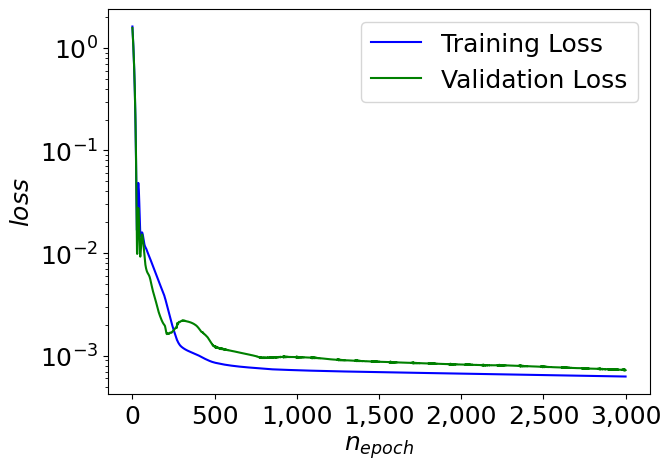

In [60]:
solver.plot_loss_history()

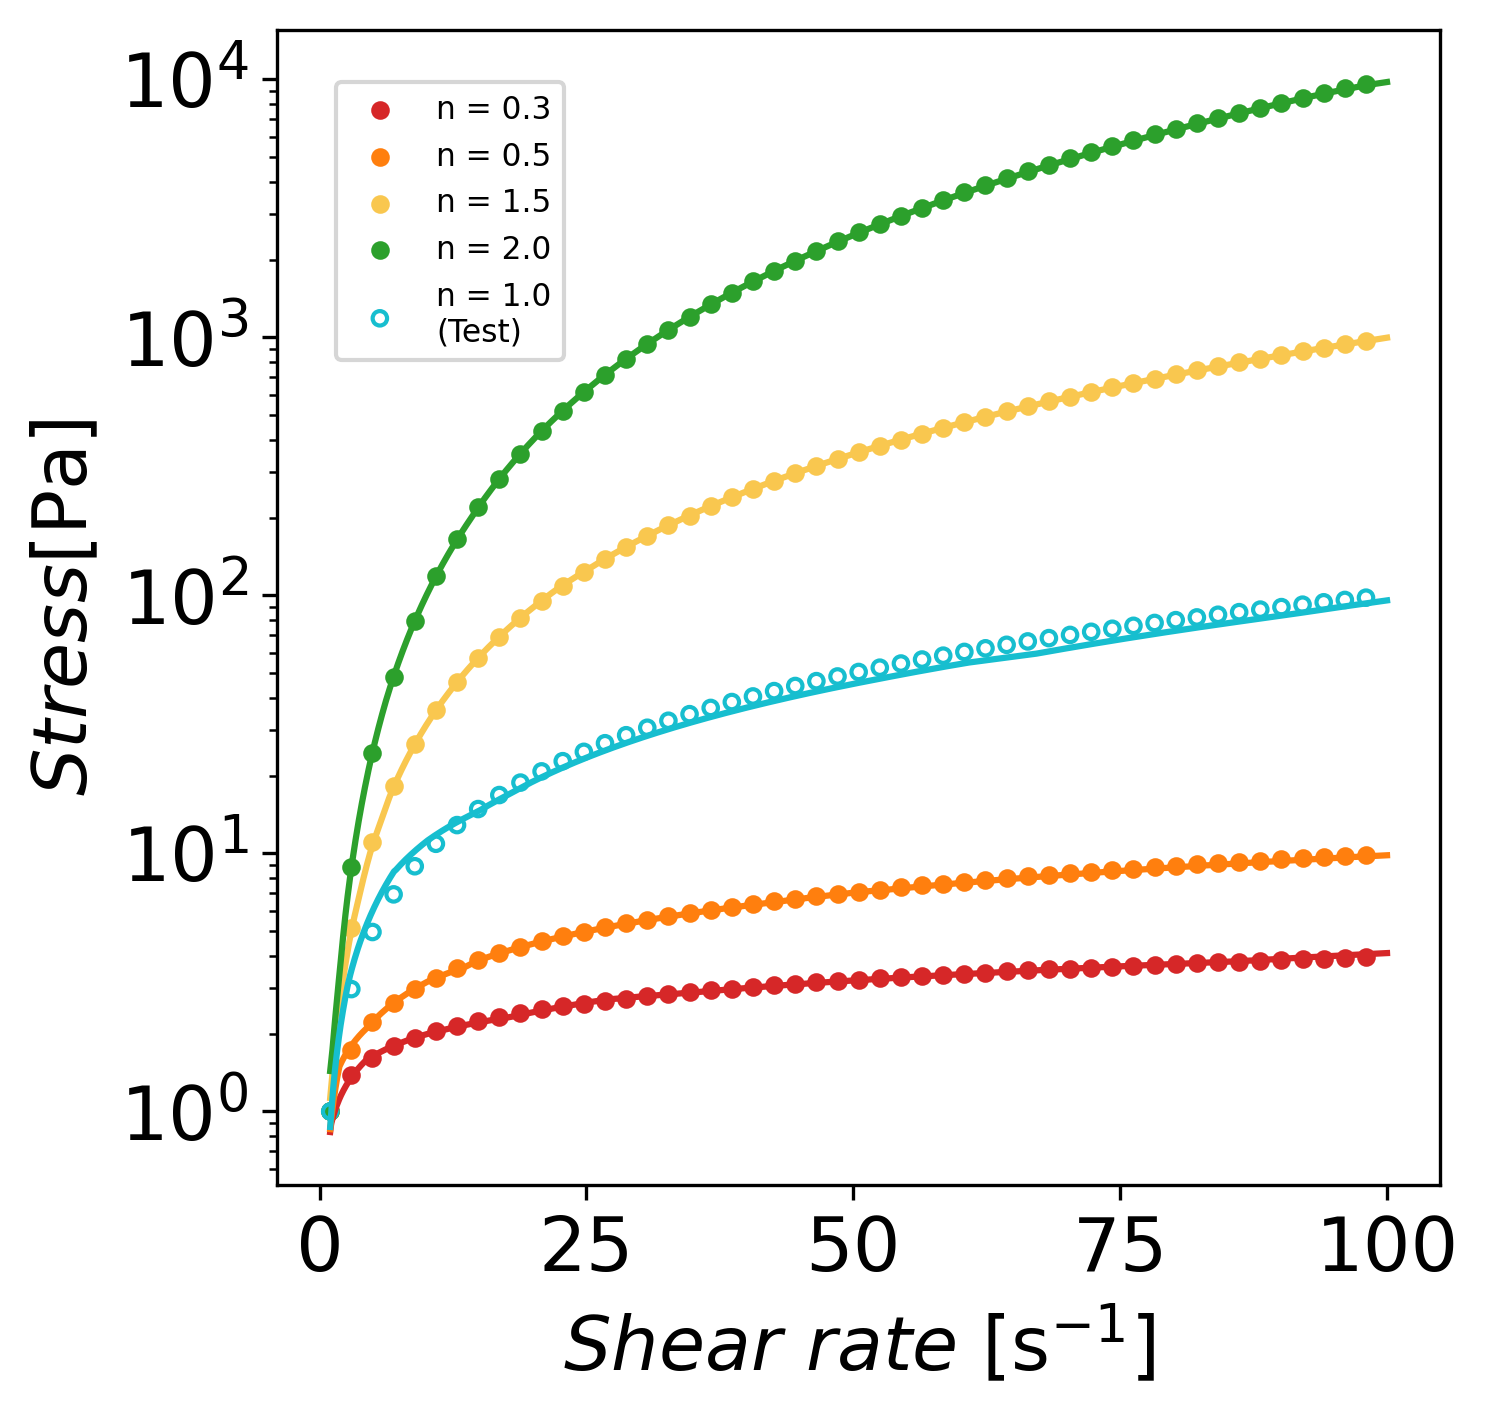

In [61]:
model_HF_l.eval()
model_HF_nl.eval()
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:brown', 'tab:pink']

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors

N=df_hf['n'].unique()
for i, value in enumerate(N):
    test_data=df_hf[df_hf.n==value]
    
    # 计算等间隔的索引
    num_points = len(test_data)
    step = max(1, num_points // 50)  # 确保步长至少为1
    sampled_indices = range(0, num_points, step)
    
    # 按等间隔取点
    sampled_test_data = test_data.iloc[sampled_indices]

    x1_test = torch.tensor(test_data['shear rate'].values, dtype=torch.float32).view(-1, 1)
    x2_test = torch.tensor(test_data['n'].values, dtype=torch.float32).view(-1, 1)
    y1_test = torch.tensor(test_data['stress'].values, dtype=torch.float32).view(-1, 1)
    x1_test=torch.log10(x1_test)
    y1_test=torch.log10(y1_test)
    x1_test = norm(x1_test, lb[0], ub[0])
    x2_test = norm(x2_test, lb[1], ub[1])
    y1_test = norm(y1_test, lb[2], ub[2]) 
    
    # 将 NumPy 数组转换为 PyTorch 张量
    X_MF = torch.cat([x1_test, x2_test], dim=1)
    y_MF = model_HF_nl(X_MF) + model_HF_l(X_MF)
    # 反归一化 y_MF
    y_MF_denorm = denorm(y_MF.detach().numpy(), lb[2], ub[2])
     # 绘制数据
   
    ax.plot(10**(denorm(x1_test,lb[0],ub[0])), 10**y_MF_denorm, color=colors[i % len(colors)])
   
    if value == 1.0:
        ax.scatter(sampled_test_data['shear rate'].values, sampled_test_data['stress'].values, color=colors[i % len(colors)], marker='o', facecolors='none', 
                   label=f'n = {value}\n(Test)',s=12)
    else:
       ax.scatter(sampled_test_data['shear rate'].values, sampled_test_data['stress'].values, color=colors[i % len(colors)], marker='o', 
                  label=f'n = {value}',s=12)
       
    
    
# ax.axvspan(1, 100, color='gray', alpha=0.2) 突出标记
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$Stress$$\mathrm{[Pa]}$')
ax.set_xlabel('$Shear\ rate$ $\mathrm{[s^{-1}]}$')
# ax.grid()
# 调整图例的大小和位置
legend = ax.legend(fontsize=7.5, loc='lower right', bbox_to_anchor=(0.26, 0.7))
#ax.invert_xaxis()
plt.show()

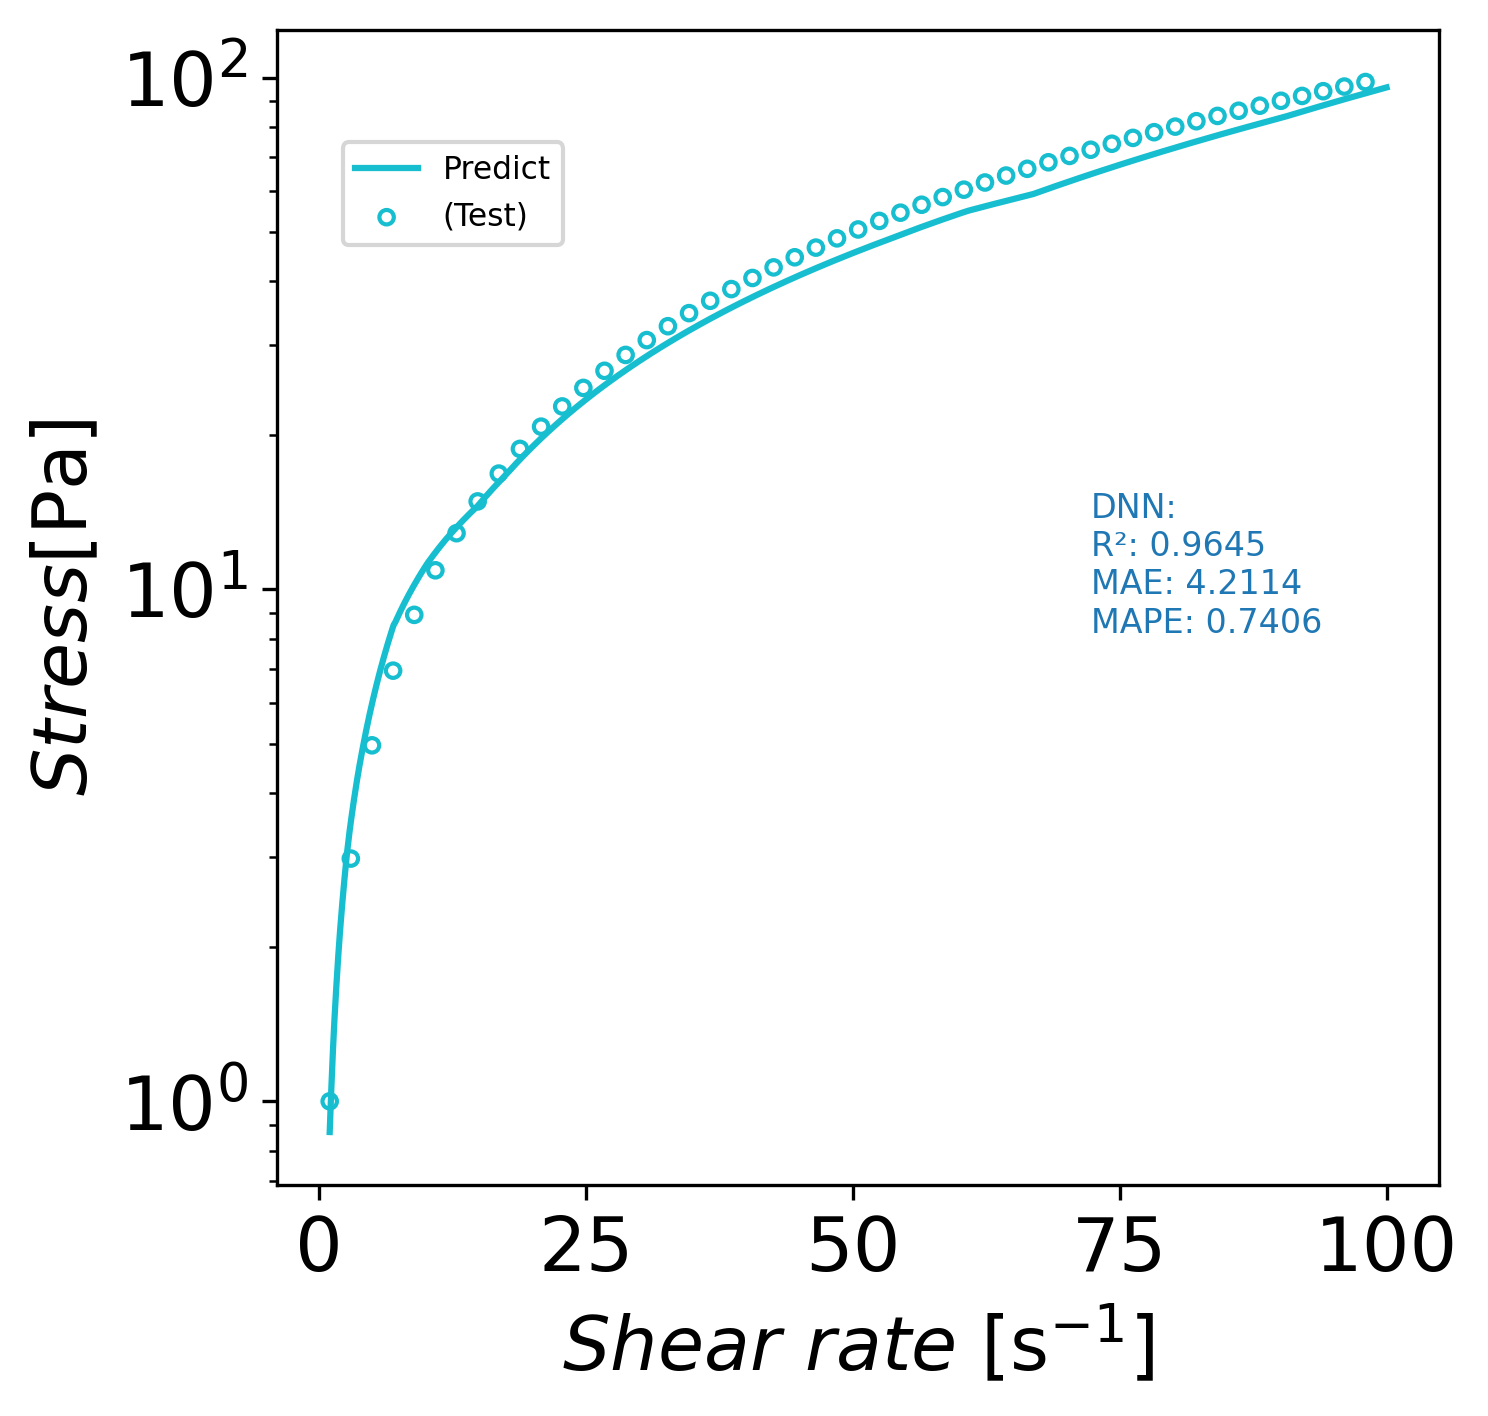

In [62]:
model_HF_l.eval()
model_HF_nl.eval()
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:brown', 'tab:pink']

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors

N=df_hf['n'].unique()
R2 = 0
MAE = 0
MSE = 0
for i, value in enumerate(N):
    test_data=df_hf[df_hf.n==value]
    
    # 计算等间隔的索引
    num_points = len(test_data)
    step = max(1, num_points // 50)  # 确保步长至少为1
    sampled_indices = range(0, num_points, step)
    
    # 按等间隔取点
    sampled_test_data = test_data.iloc[sampled_indices]

    x1_test = torch.tensor(test_data['shear rate'].values, dtype=torch.float32).view(-1, 1)
    x2_test = torch.tensor(test_data['n'].values, dtype=torch.float32).view(-1, 1)
    y1_test = torch.tensor(test_data['stress'].values, dtype=torch.float32).view(-1, 1)
    x1_test=torch.log10(x1_test)
    y1_test=torch.log10(y1_test)
    x1_test = norm(x1_test, lb[0], ub[0])
    x2_test = norm(x2_test, lb[1], ub[1])
    y1_test = norm(y1_test, lb[2], ub[2]) 
    
    # 将 NumPy 数组转换为 PyTorch 张量
    X_MF = torch.cat([x1_test, x2_test], dim=1)
    y_MF = model_HF_nl(X_MF) + model_HF_l(X_MF)
    # 反归一化 y_MF
    y_MF_denorm = denorm(y_MF.detach().numpy(), lb[2], ub[2])
     # 绘制数据
   
    if value == 1.0:
        ax.plot(10**(denorm(x1_test,lb[0],ub[0])), 10**y_MF_denorm, color=colors[i % len(colors)],label=f'Predict')
        ax.scatter(sampled_test_data['shear rate'].values, sampled_test_data['stress'].values, color=colors[i % len(colors)], marker='o', facecolors='none', 
                   label=f'(Test)',s=12)
        R2 = r2_score(10**y_MF_denorm, test_data['stress'].values)
        MAE = mean_absolute_error(10**y_MF_denorm, test_data['stress'].values)
        MSE = mean_squared_error(10**y_MF_denorm, test_data['stress'].values)
        # 计算 MAPE
        def calculate_smape(y_true, y_pred):
    # 计算每个样本的对称平均绝对百分比误差
           numerator = np.abs(y_true - y_pred)
           denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
           smape = np.mean(numerator / denominator) 
           return smape

        SMAPE = calculate_smape(test_data['stress'].values, 10**y_MF_denorm)
    
# ax.axvspan(1, 100, color='gray', alpha=0.2) 突出标记
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$Stress$$\mathrm{[Pa]}$')
ax.set_xlabel('$Shear\ rate$ $\mathrm{[s^{-1}]}$')
# ax.grid()
# 调整图例的大小和位置
legend = ax.legend(fontsize=7.5, loc='lower right', bbox_to_anchor=(0.26, 0.8))
ax.text(0.7, 0.6, f'DNN:\nR²: {R2:.4f}\nMAE: {MAE:.4f}\nMAPE: {SMAPE:.4f}', 
        transform=ax.transAxes, fontsize=8, verticalalignment='top', bbox=None,color='tab:blue')

#ax.invert_xaxis()
plt.show()

In [63]:
torch.save(model_HF_l,'model/viscous_fluid/paw_law_gru_l')
torch.save(model_HF_nl,'model/viscous_fluid/paw_law_gru_nl')

/tmp/ipykernel_32065/4234700657.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dnn_l=torch.load('model/viscous_fluid/paw_law_dnn_l')
/tmp/ipykernel_32065/42347006

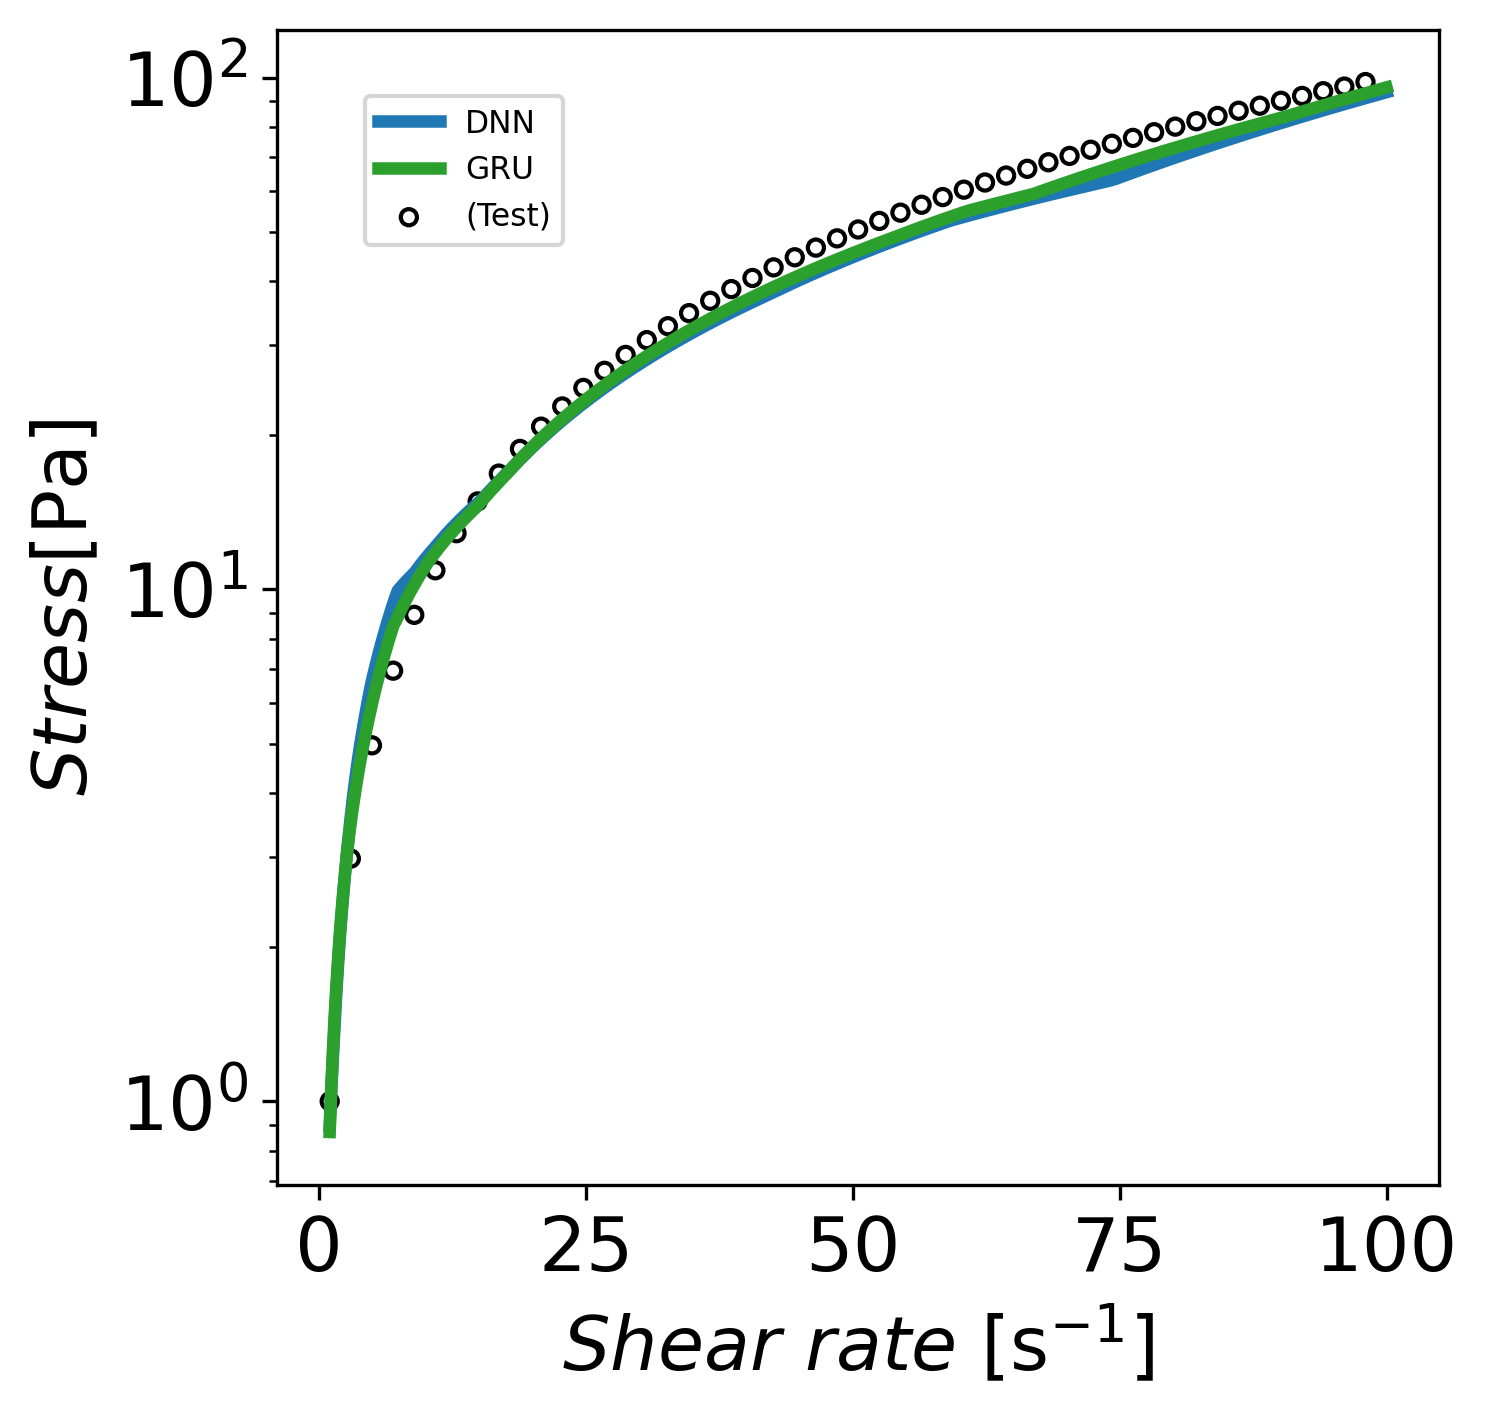

In [68]:
model_dnn_l=torch.load('model/viscous_fluid/paw_law_dnn_l')
model_dnn_nl=torch.load('model/viscous_fluid/paw_law_dnn_nl')
model_gru_l=torch.load('model/viscous_fluid/paw_law_gru_l')
model_gru_nl=torch.load('model/viscous_fluid/paw_law_gru_nl')

plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['#000000','tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:brown', 'tab:pink']

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors

N=df_hf['n'].unique()
R2 = 0
MAE = 0
MSE = 0
for i, value in enumerate(N):
    test_data=df_hf[df_hf.n==value]
    
    # 计算等间隔的索引
    num_points = len(test_data)
    step = max(1, num_points // 50)  # 确保步长至少为1
    sampled_indices = range(0, num_points, step)
    
    # 按等间隔取点
    sampled_test_data = test_data.iloc[sampled_indices]

    x1_test = torch.tensor(test_data['shear rate'].values, dtype=torch.float32).view(-1, 1)
    x2_test = torch.tensor(test_data['n'].values, dtype=torch.float32).view(-1, 1)
    y1_test = torch.tensor(test_data['stress'].values, dtype=torch.float32).view(-1, 1)
    x1_test=torch.log10(x1_test)
    y1_test=torch.log10(y1_test)
    x1_test = norm(x1_test, lb[0], ub[0])
    x2_test = norm(x2_test, lb[1], ub[1])
    y1_test = norm(y1_test, lb[2], ub[2]) 
    
    # 将 NumPy 数组转换为 PyTorch 张量
    X_MF = torch.cat([x1_test, x2_test], dim=1)
    y_MF = model_dnn_nl(X_MF) + model_dnn_l(X_MF)
    # 反归一化 y_MF
    y_MF_denorm = denorm(y_MF.detach().numpy(), lb[2], ub[2])

    # 将 NumPy 数组转换为 PyTorch 张量
    y_MF_gru = model_gru_nl(X_MF) + model_gru_l(X_MF)
    # 反归一化 y_MF
    y_MF_denorm_gru = denorm(y_MF_gru.detach().numpy(), lb[2], ub[2])
     # 绘制数据
   
    if value == 1.0:
        ax.plot(10**(denorm(x1_test,lb[0],ub[0])), 10**y_MF_denorm, color=colors[6],label='DNN',lw=3)
        ax.plot(10**(denorm(x1_test,lb[0],ub[0])), 10**y_MF_denorm_gru, color=colors[4],label='GRU',lw=3)
        ax.scatter(sampled_test_data['shear rate'].values, sampled_test_data['stress'].values, color=colors[0], marker='o', facecolors='none', 
                   label=f'(Test)',s=15)
        R2 = r2_score(10**y_MF_denorm, test_data['stress'].values)
        MAE = mean_absolute_error(10**y_MF_denorm, test_data['stress'].values)
        MSE = mean_squared_error(10**y_MF_denorm, test_data['stress'].values)
        # 计算 MAPE
        def calculate_smape(y_true, y_pred):
    # 计算每个样本的对称平均绝对百分比误差
           numerator = np.abs(y_true - y_pred)
           denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
           smape = np.mean(numerator / denominator) 
           return smape

        SMAPE = calculate_smape(test_data['stress'].values, 10**y_MF_denorm)
ax.set_yscale('log')
ax.set_ylabel('$Stress$$\mathrm{[Pa]}$')
ax.set_xlabel('$Shear\ rate$ $\mathrm{[s^{-1}]}$')
# ax.grid()
# 调整图例的大小和位置
legend = ax.legend(fontsize=7.5, loc='lower right', bbox_to_anchor=(0.26, 0.8))

#ax.invert_xaxis()
plt.show()

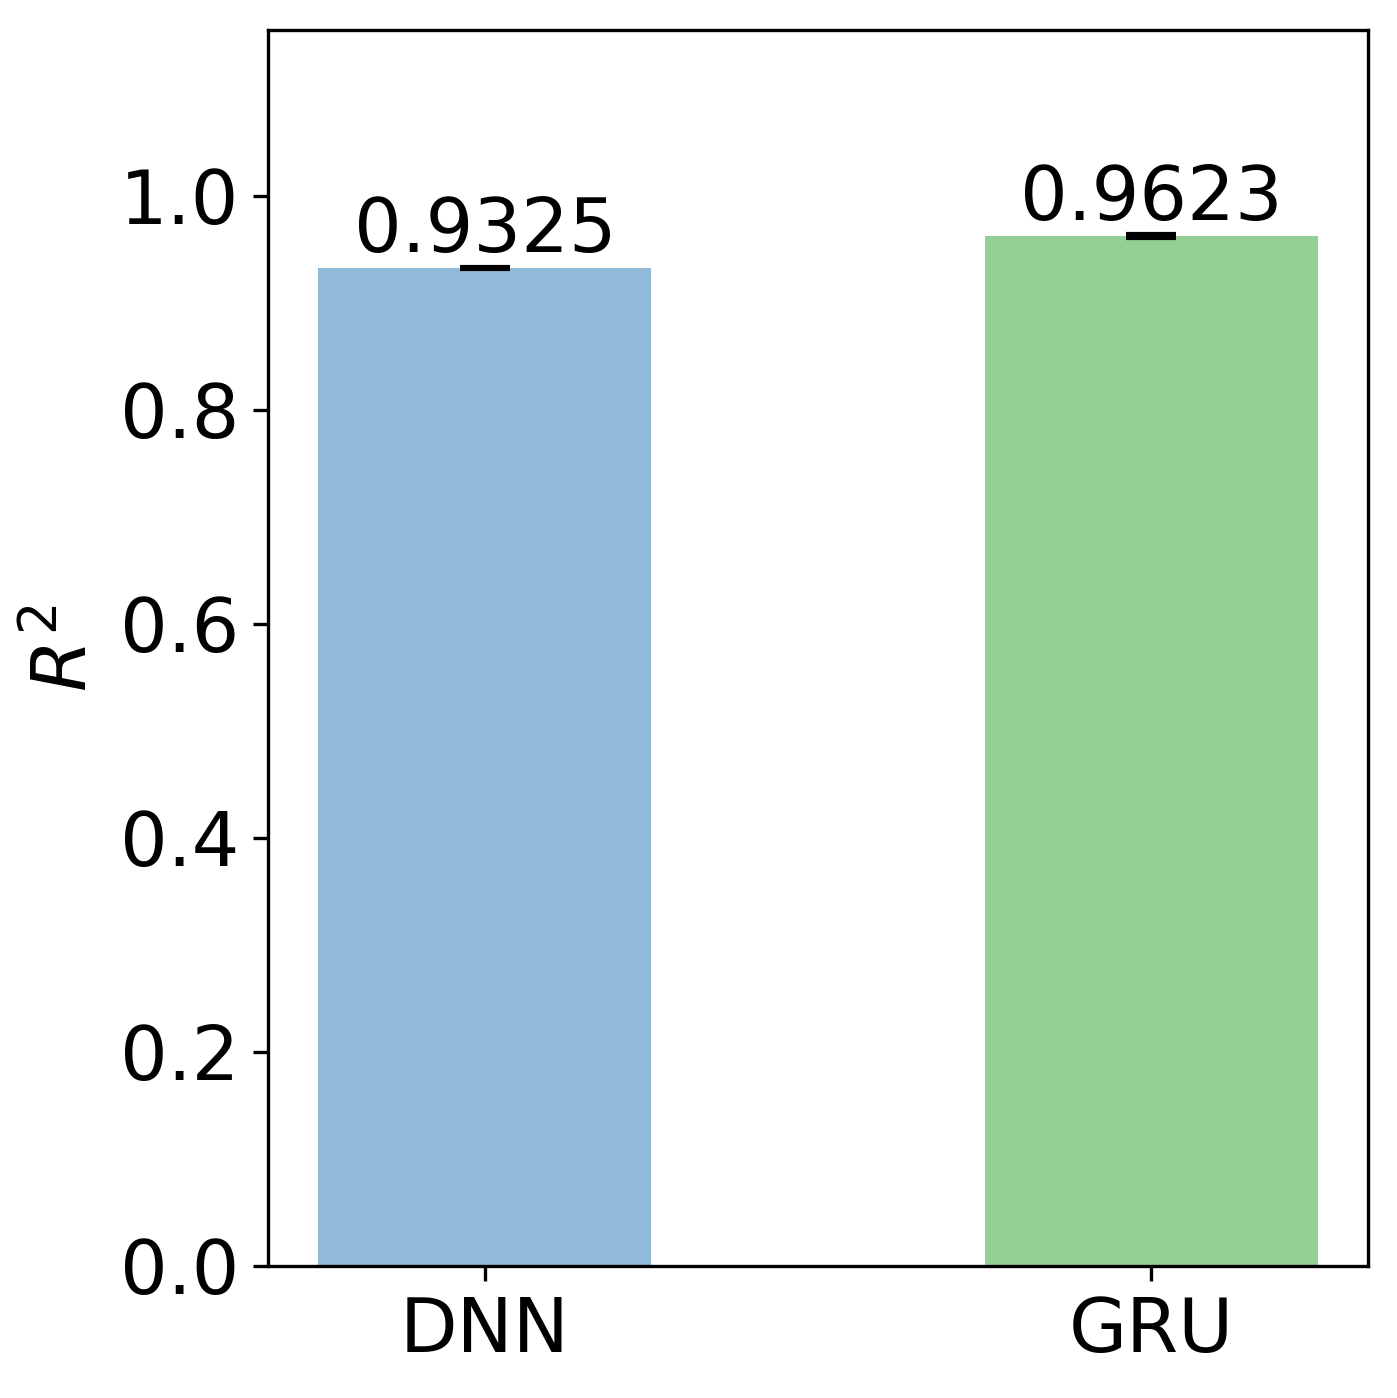

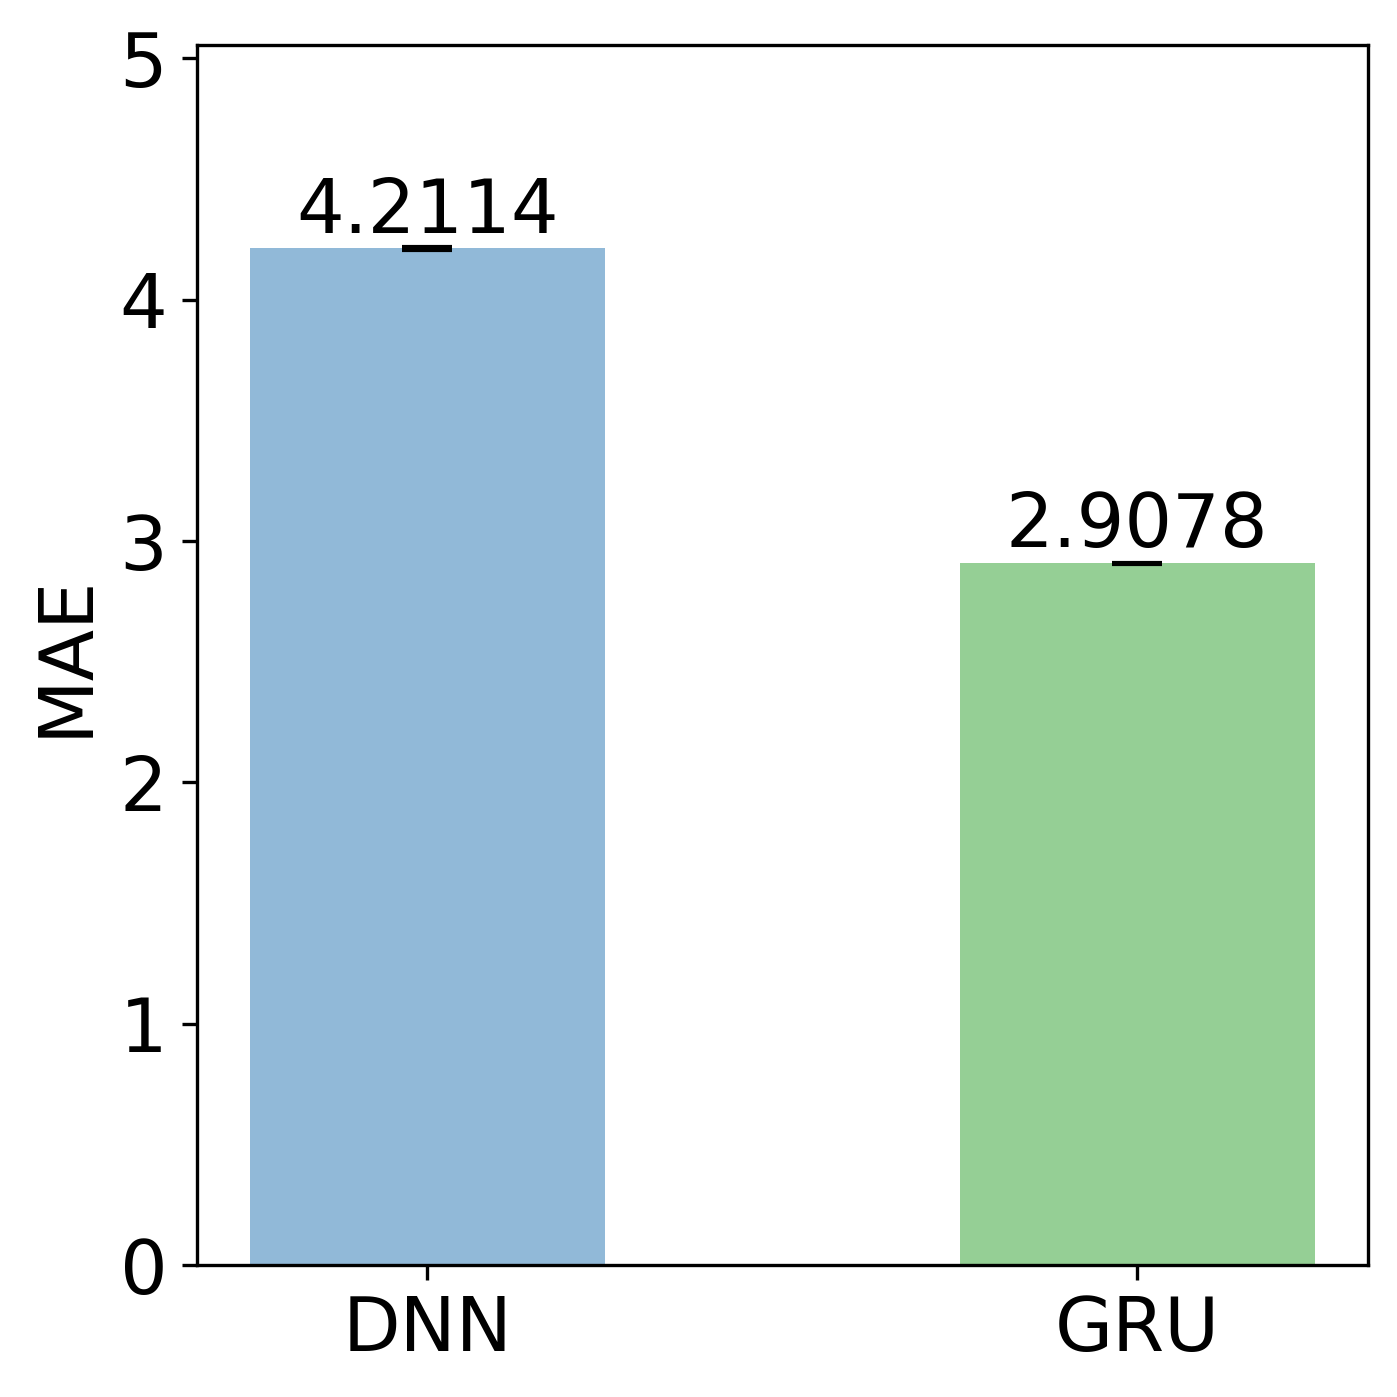

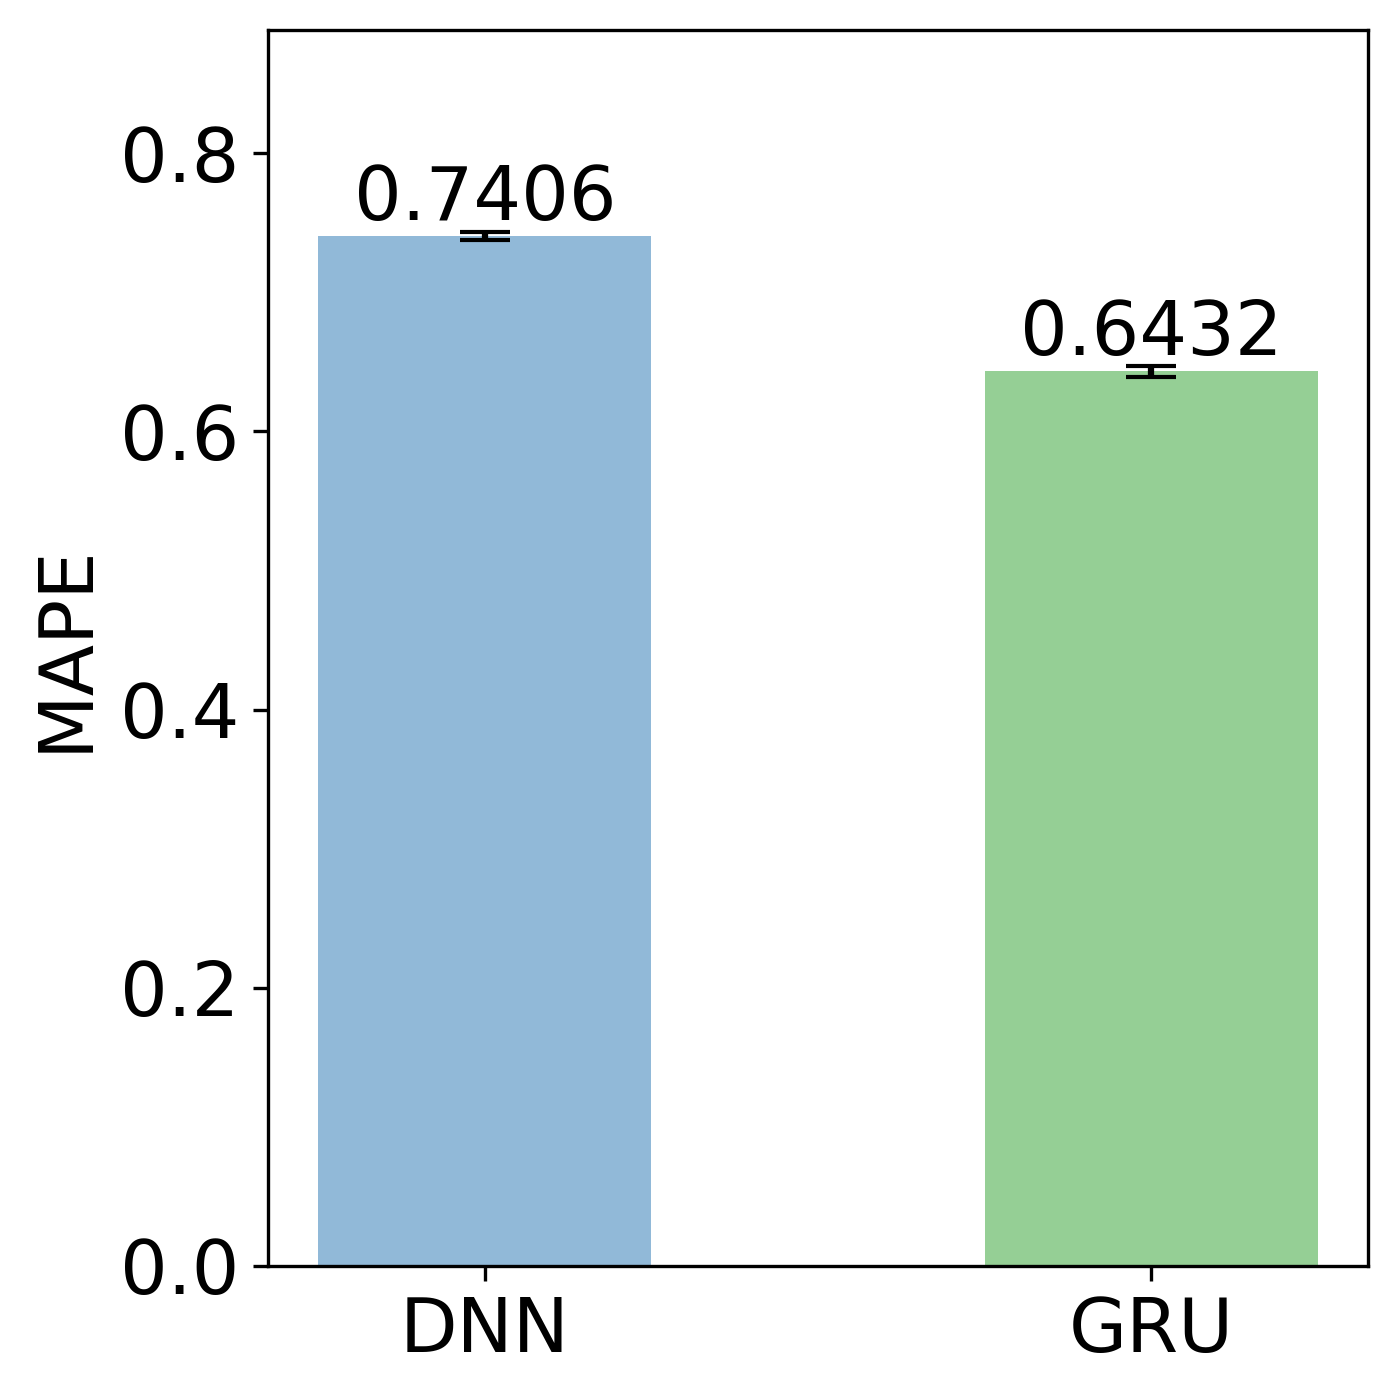

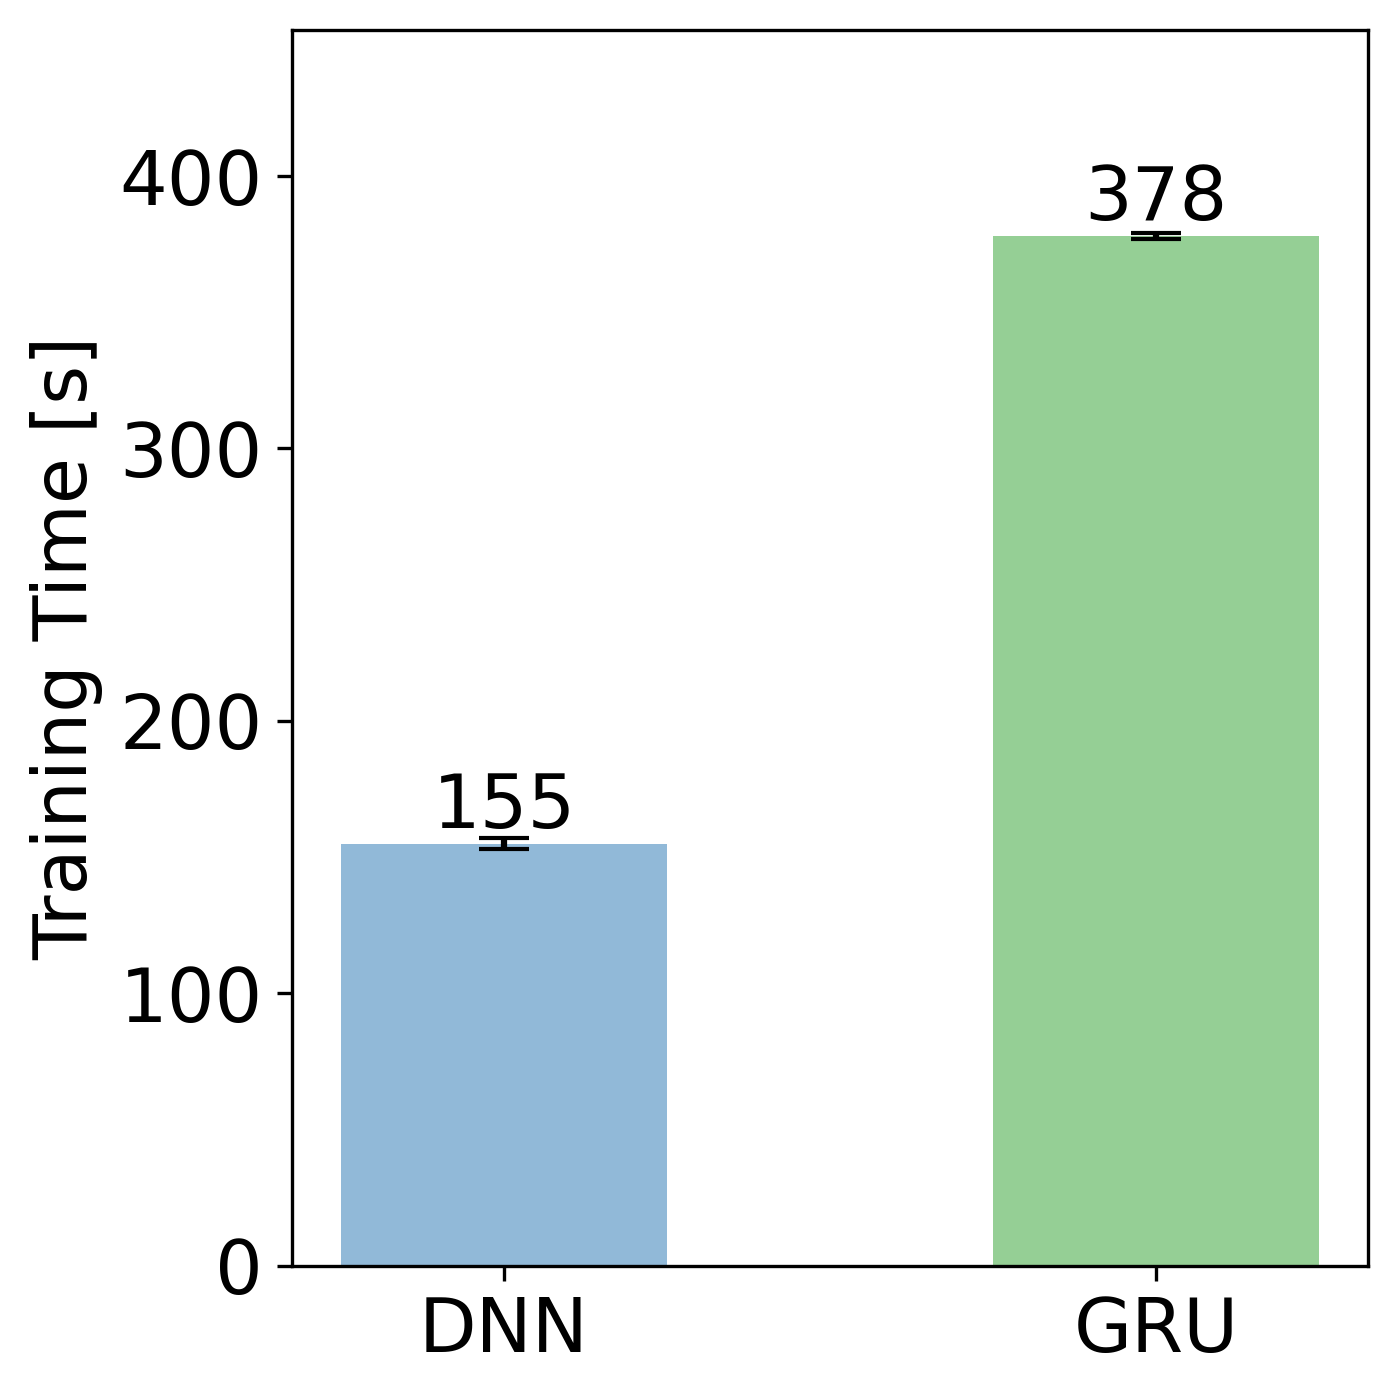

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
# 示例数据（请根据实际情况替换）
metrics = [f'$R^{2}$', 'MAE', 'MAPE', 'Training Time']
dnn_values = [0.9325, 4.2114, 0.7406, 155]  # 示例DNN值
gru_values = [0.9623, 2.9078, 0.6432, 378]  # 示例GRU值

# 误差棒（请根据实际情况替换）
dnn_errors = [0.001, 0.005, 0.003, 2]  # DNN的误差
gru_errors = [0.002, 0.002, 0.004, 1]  # GRU的误差

# Nature 科研配色
dnn_color = '#377eb8'  # 蓝色
gru_color = 'tab:green'  # 绿色
# 自定义渐变颜色
def create_gradient_cmap(color1, color2, gamma=2.0, N=256):
    """
    创建渐变颜色映射
    :param color1: 渐变的起点颜色
    :param color2: 渐变的终点颜色
    :param gamma: 控制渐变的平滑度
    :param N: 渐变的分辨率
    :return: 渐变颜色映射
    """
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1, color2], N=N)
    cmap._init()
    cmap._lut[:, -1] = np.linspace(0, 1, cmap.N + 3) ** gamma  # 调整透明度
    return cmap
# 柱状图宽度
bar_width = 0.1

# 绘图
for i, metric in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
    # 计算柱状图位置
    x = [1,1.2]  # 2 个模型：DNN 和 GRU
    
     # 创建渐变颜色映射
    dnn_cmap = create_gradient_cmap('lightblue', dnn_color)
    gru_cmap = create_gradient_cmap('white', gru_color)
    
    # 绘制DNN柱状图
    dnn_bar = ax.bar(x[0], dnn_values[i], width=bar_width, color=dnn_cmap(0.8), yerr=dnn_errors[i], capsize=6, label='DNN')
    
    # 绘制GRU柱状图
    gru_bar = ax.bar(x[1], gru_values[i], width=bar_width, color=gru_cmap(0.8), yerr=gru_errors[i], capsize=6, label='GRU')
    
    # 显示柱状图数字
    for bar in [dnn_bar, gru_bar]:
        for rect in bar:
            height = rect.get_height()
            if i!=3:
              ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom', fontsize=18)
            else:
              ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom', fontsize=18)
    # 设置y轴标签
    if i!=3:
      ax.set_ylabel(metric, fontsize=18)
    else:
      ax.set_ylabel(metric+' [s]', fontsize=18)
    
    # 设置x轴标签
    ax.set_xticks(x)
    ax.set_xticklabels(['DNN', 'GRU'], fontsize=18)  # x轴显示DNN和GRU
    # 调整布局
    # 调整y轴范围，留出更多空白
    max_value = max(dnn_values[i], gru_values[i])  # 获取当前指标的最大值
    ax.set_ylim(0, max_value * 1.2)  # 设置y轴上限为最大值的1.2倍
    plt.tight_layout()
    
    # 显示图形
    plt.show()